# TP3 - Vision Transformers - CEIA

Ecosistema actual, Huggingface y modelos pre entrenados.

Alumno: Isidro Marco Joel (a1520)

---

# Tarea: Fine-tuning de un modelo Vision Transformer

1. **Objetivo**: 
   Seleccione un modelo preentrenado que utilice Vision Transformers (ViTs) y un conjunto de datos adecuado. Realice un proceso de fine-tuning del modelo seleccionado.

   Pueden encontrar la documentacion de Transformers de Hugging Face en [Link](https://huggingface.co/docs/transformers/index)

   Datasets de imágenes en Hugging Face [Link](https://huggingface.co/datasets?modality=modality:image&sort=downloads)

   O pueden usar fuentes de preferencia.

   
2. **Una vez finalizado el fine-tuning**:
   - Justifique la elección del modelo preentrenado y del dataset.
   - Explique el proceso de fine-tuning realizado, especificando los parámetros ajustados y las modificaciones necesarias.
   - Evalúe el rendimiento del modelo preentrenado sin ajustes y compárelo con los resultados obtenidos tras el fine-tuning, discutiendo las mejoras o diferencias observadas.
---

## Elección del modelo: microsoft/cvt-13


Se ha elegido el modelo microsoft/cvt-13, un Vision Transformer que combina capas convolucionales con autoatención, optimizando así el balance entre eficiencia y precisión. Esta arquitectura híbrida permite al modelo capturar tanto características locales como globales de las imágenes, lo cual es especialmente útil para identificar detalles distintivos en categorías visuales complejas, como las razas de mascotas. Además, al estar preentrenado en el dataset imagenet-1k, el modelo cuenta con representaciones generales que pueden adaptarse bien al conjunto de datos de bharat-raghunathan/indian-foods-dataset mediante fine-tuning.

link: https://huggingface.co/microsoft/cvt-13

## Elección del dataset: indian-foods-dataset

El dataset "bharat-raghunathan/indian-foods-dataset" incluye dos tipos de datos: imágenes, representadas en el campo "image", y etiquetas de clase en el campo "target", que clasifica los platos en 15 categorías distintas, como biryani, dosa, naan, entre otros. Con un total de 4,770 muestras (3,809 para entrenamiento y 961 para prueba), el tamaño reducido del dataset justifica el uso de un modelo preentrenado, ya que esto permite aprovechar características visuales generales previamente aprendidas, facilitando así un ajuste fino efectivo en un conjunto de datos limitado en cantidad pero diverso en clases.

link: https://huggingface.co/datasets/bharat-raghunathan/indian-foods-dataset

## Carga del dataset

In [1]:
from datasets import load_dataset

dataset = load_dataset('bharat-raghunathan/indian-foods-dataset')

/home/isidro-marco/.cache/pypoetry/virtualenvs/tps-ceia-vit-bhyr8ZO9-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 961/961 [00:00<00:00, 3127.91 examples/s]


In [2]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3809
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 961
    })
})


In [3]:
print(dataset['train'].features)
print(dataset['train'][0])
print(dataset['train'].features['label'].names)


print(f"Tamaño del conjunto de entrenamiento: {len(dataset['train'])}")
print(f"Tamaño del conjunto de validación: {len(dataset['test'])}")

{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['biryani', 'cholebhature', 'dabeli', 'dal', 'dhokla', 'dosa', 'jalebi', 'kathiroll', 'kofta', 'naan', 'pakora', 'paneer', 'panipuri', 'pavbhaji', 'vadapav'], id=None)}
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=300x300 at 0x7F151E95B010>, 'label': 0}
['biryani', 'cholebhature', 'dabeli', 'dal', 'dhokla', 'dosa', 'jalebi', 'kathiroll', 'kofta', 'naan', 'pakora', 'paneer', 'panipuri', 'pavbhaji', 'vadapav']
Tamaño del conjunto de entrenamiento: 3809
Tamaño del conjunto de validación: 961


In [4]:
id2label = {id:label for id, label in enumerate(dataset['train'].features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'biryani',
 1: 'cholebhature',
 2: 'dabeli',
 3: 'dal',
 4: 'dhokla',
 5: 'dosa',
 6: 'jalebi',
 7: 'kathiroll',
 8: 'kofta',
 9: 'naan',
 10: 'pakora',
 11: 'paneer',
 12: 'panipuri',
 13: 'pavbhaji',
 14: 'vadapav'}

A continuación se muestran algunas imágenes del dataset junto a las respectivas categorias

In [5]:
import matplotlib.pyplot as plt

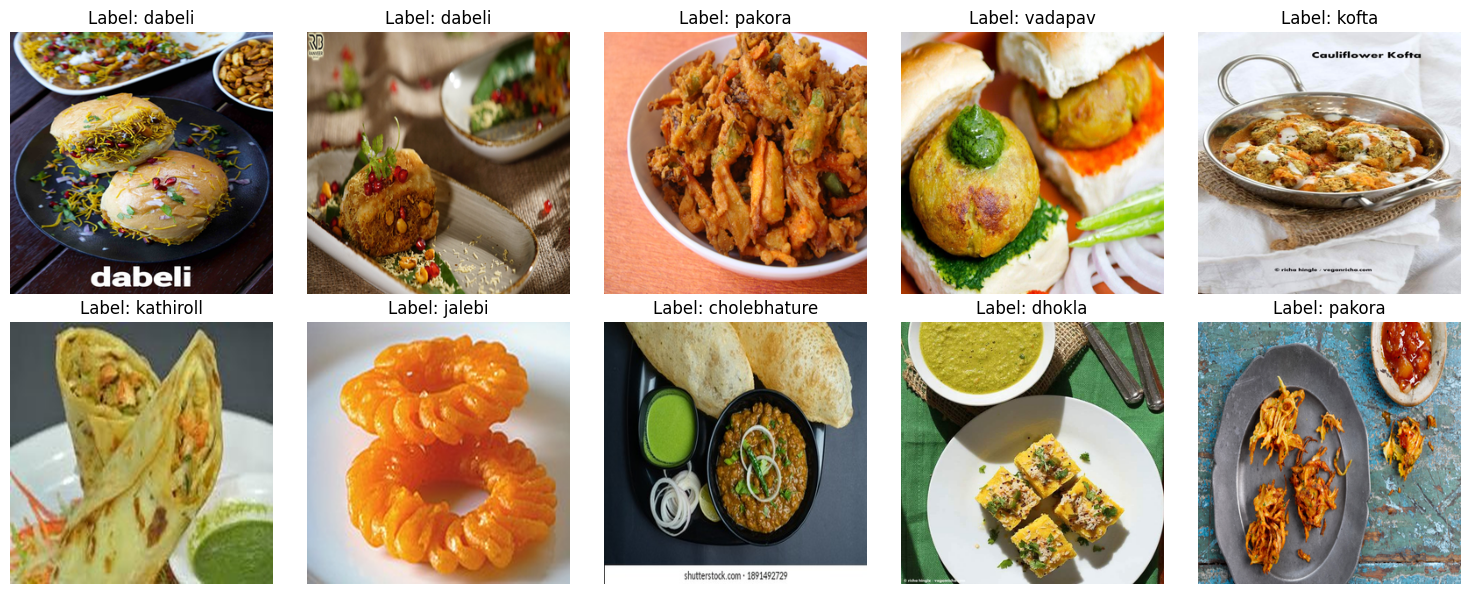

In [ ]:
random_sample = dataset['train'].shuffle(seed=42).select([i for i in range(10)])


fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()


for i in range(10):
    image = random_sample[i]['image']
    label = random_sample[i]['label']
    class_name = dataset['train'].features['label'].int2str(label)
    
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f"Label: {class_name}")

plt.tight_layout()
plt.show()

## Carga del modelo preentrenado

In [8]:
import torch
from transformers import AutoFeatureExtractor, CvtForImageClassification
from transformers import TrainingArguments, Trainer
import requests
from PIL import Image
from torch.utils.data import DataLoader
import numpy as np

In [9]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [10]:
device

'cuda'

La elección de AutoFeatureExtractor y CvtForImageClassification se justifica porque, a diferencia de los modelos Vision Transformer tradicionales, el modelo CvT (Convolutional Vision Transformer) combina la capacidad de atención propia de los ViTs con capas convolucionales en las etapas iniciales del modelo. Estas capas convolucionales mejoran la extracción de características locales en imágenes, lo que es particularmente útil para reconocer detalles visuales en tipos de datos complejos, como los platos de comida, que tienen texturas y patrones específicos.

Usando AutoFeatureExtractor, aplicamos preprocesamiento que ajusta las imágenes de entrada al formato esperado por el modelo CvT (es decir, resolución y normalización específicas). Este paso es esencial porque un ViT tradicional espera entradas en un formato específico de tensores con normalización basada en el dataset de preentrenamiento, y AutoFeatureExtractor automatiza esta transformación para mantener la compatibilidad. 

In [11]:
feature_extractor = AutoFeatureExtractor.from_pretrained('microsoft/cvt-13')
model = CvtForImageClassification.from_pretrained('microsoft/cvt-13')

/home/isidro-marco/.cache/pypoetry/virtualenvs/tps-ceia-vit-bhyr8ZO9-py3.10/lib/python3.10/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


A continuación se realiza una inferencia de prueba sobre el modelo preentrenado, para verificar el correcto funcionamiento del mismo

In [12]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

Predicted class: tabby, tabby cat


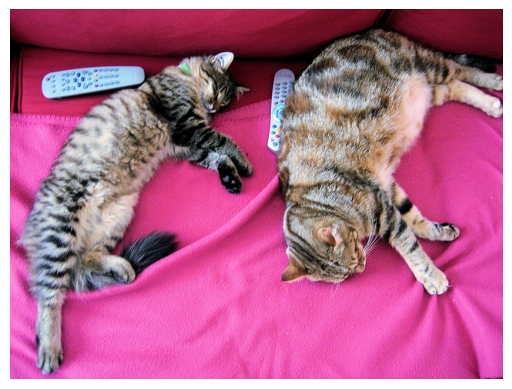

In [ ]:
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

plt.imshow(image)
plt.axis('off')
plt.show()

## Preprocesamiento

In [ ]:
torch.set_float32_matmul_precision("medium")

In [ ]:
def preprocess_function(examples):
    inputs = feature_extractor(images=examples['image'], return_tensors="pt", padding=True)
    inputs['labels'] = torch.tensor([0] * len(examples['label']), dtype=torch.float)
    return inputs

def transform(example):
    inputs = feature_extractor(images=example['image'].convert("RGB"), return_tensors="pt")
    example['pixel_values'] = inputs['pixel_values'].squeeze()
    example['label'] = example['label']
    return example

In [22]:
dataset['train'][17]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=300x300>,
 'label': 0}

En la función de transformor se debio aplicar una conversion a RGB, debido a que como se puede observar anteriormente algunas imágenes del modelo estaban en formato RGBA y esto ocacionaba problamas de dimensionalidad durante el entrenamiento.

In [ ]:
train_dataset = dataset['train'].map(transform)
test_dataset = dataset['test'].map(transform)

train_dataset.set_format(type='torch', columns=['pixel_values', 'label'])
test_dataset.set_format(type='torch', columns=['pixel_values', 'label'])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)

Map:   0%|          | 0/3809 [00:00<?, ? examples/s]

Map:  28%|██▊       | 1065/3809 [00:50<10:48,  4.23 examples/s]/home/isidro-marco/.cache/pypoetry/virtualenvs/tps-ceia-vit-bhyr8ZO9-py3.10/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Map: 100%|██████████| 961/961 [00:49<00:00, 19.50 examples/s] 


## Fine-Tuning

In [24]:
import os
os.environ["WANDB_DISABLED"] = "true" # no utilizamos weights and biases

In [ ]:
# Definir los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./cvt13-finetuned-indian-food", 
    evaluation_strategy="epoch", 
    learning_rate=2e-5, #se utilizo un valor bajo debido a tratarse de un fine-tuning
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,  
    num_train_epochs=20,  
    weight_decay=0.01, 
    logging_dir='./logs',  
    log_level='info',  
    fp16=True, 
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = np.mean(preds == labels)
    return {"accuracy": accuracy}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics, 
)

# Entrenar el modelo
trainer.train()

/home/isidro-marco/.cache/pypoetry/virtualenvs/tps-ceia-vit-bhyr8ZO9-py3.10/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using auto half precision backend
The following columns in the training set don't have a corresponding argument in `CvtForImageClassification.forward` and have been ignored: image. If image are not expected by `CvtForImageClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 3,809
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Tota

The following columns in the evaluation set don't have a corresponding argument in `CvtForImageClassification.forward` and have been ignored: image. If image are not expected by `CvtForImageClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 961
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `CvtForImageClassification.forward` and have been ignored: image. If image are not expected by `CvtForImageClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 961
  Batch size = 16
Saving model checkpoint to ./cvt13-finetuned-indian-food/checkpoint-500
Configuration saved in ./cvt13-finetuned-indian-food/checkpoint-500/config.json
Model weights saved in ./cvt13-finetuned-indian-food/checkpoint-500/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `CvtForImageClassification.forwar

TrainOutput(global_step=4780, training_loss=0.9850992625727314, metrics={'train_runtime': 4273.8044, 'train_samples_per_second': 17.825, 'train_steps_per_second': 1.118, 'total_flos': 1.3758933803876352e+18, 'train_loss': 0.9850992625727314, 'epoch': 20.0})

In [26]:
eval_results = trainer.evaluate()
print(eval_results)

The following columns in the evaluation set don't have a corresponding argument in `CvtForImageClassification.forward` and have been ignored: image. If image are not expected by `CvtForImageClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 961
  Batch size = 16


{'eval_loss': 0.20759393274784088, 'eval_accuracy': 0.9531737773152965, 'eval_runtime': 28.4762, 'eval_samples_per_second': 33.747, 'eval_steps_per_second': 2.142, 'epoch': 20.0}


In [ ]:
torch.cuda.empty_cache() # limpiamos cache

## Evaluación

In [27]:
outputs = trainer.predict(test_dataset)

The following columns in the test set don't have a corresponding argument in `CvtForImageClassification.forward` and have been ignored: image. If image are not expected by `CvtForImageClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 961
  Batch size = 16


In [28]:
outputs.metrics

{'test_loss': 0.20759393274784088,
 'test_accuracy': 0.9531737773152965,
 'test_runtime': 31.3108,
 'test_samples_per_second': 30.692,
 'test_steps_per_second': 1.948}

In [29]:
labels = train_dataset.features['label'].names

In [30]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

In [31]:
y_pred_filtered = np.where(y_pred < len(labels), y_pred, -1)

<Figure size 2000x2000 with 0 Axes>

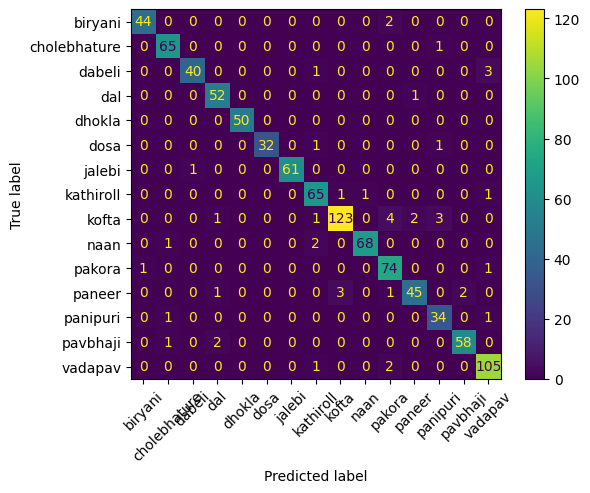

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_dataset.features['label'].names

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.show()

In [43]:
test_dataset[i]

{'label': tensor(0),
 'pixel_values': tensor([[[-1.7069, -1.6898, -1.6898,  ..., -1.1247, -1.0904, -1.1760],
          [-1.6727, -1.7240, -1.7240,  ..., -1.1247, -1.1418, -1.1760],
          [-1.6042, -1.6384, -1.6042,  ..., -1.2445, -1.2274, -1.1932],
          ...,
          [ 1.4612,  1.3242,  0.9474,  ..., -0.0287,  0.2796, -0.0972],
          [ 1.5125,  1.4612,  1.2899,  ...,  0.1768,  0.3138,  0.2796],
          [ 1.5125,  1.5468,  1.4783,  ...,  0.1083,  0.3309,  0.4166]],
 
         [[-1.6681, -1.6681, -1.6506,  ..., -1.1779, -1.1429, -1.2304],
          [-1.6331, -1.7031, -1.7031,  ..., -1.1779, -1.1954, -1.2304],
          [-1.5630, -1.5980, -1.5630,  ..., -1.3004, -1.2829, -1.2479],
          ...,
          [ 0.4328,  0.0826, -0.4251,  ..., -0.0749,  0.2927, -0.1625],
          [ 0.6254,  0.3978,  0.0476,  ...,  0.2052,  0.3627,  0.2927],
          [ 0.7304,  0.6078,  0.4328,  ...,  0.1352,  0.3627,  0.4678]],
 
         [[-1.5081, -1.4907, -1.4907,  ..., -1.0724, -1.0376, -

Como se puede observar gracias a la utilización de un modelo preentrenado y al ajuste fijo, se logro un buen modelo con un accuracy en test de 0.9531. Cabe destacar que en caso de no haber utilizado el modelo preentrenado, al contar con un baja cantidad de imágenes el resultado hubiera sido mucho peor.

A continuación se puede visualizar la prueba de inferencia realizada sobre el modelo entrenado. Al partir del tensor, para poder visualizar correctamente mente la imagen se le aplica una denormalización.

In [46]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def denormalize(image_tensor, mean, std):
    # Deshacer la normalización
    for t, m, s in zip(image_tensor, mean, std):
        t.mul_(s).add_(m)
    return image_tensor

In [52]:
import random

# Número de imágenes aleatorias que quieres mostrar
num_images_to_display = 10

# Seleccionar índices aleatorios del conjunto de test
random_indices = random.sample(range(len(test_dataset)), num_images_to_display)

random_indices

[223, 238, 517, 616, 27, 574, 203, 733, 665, 718]

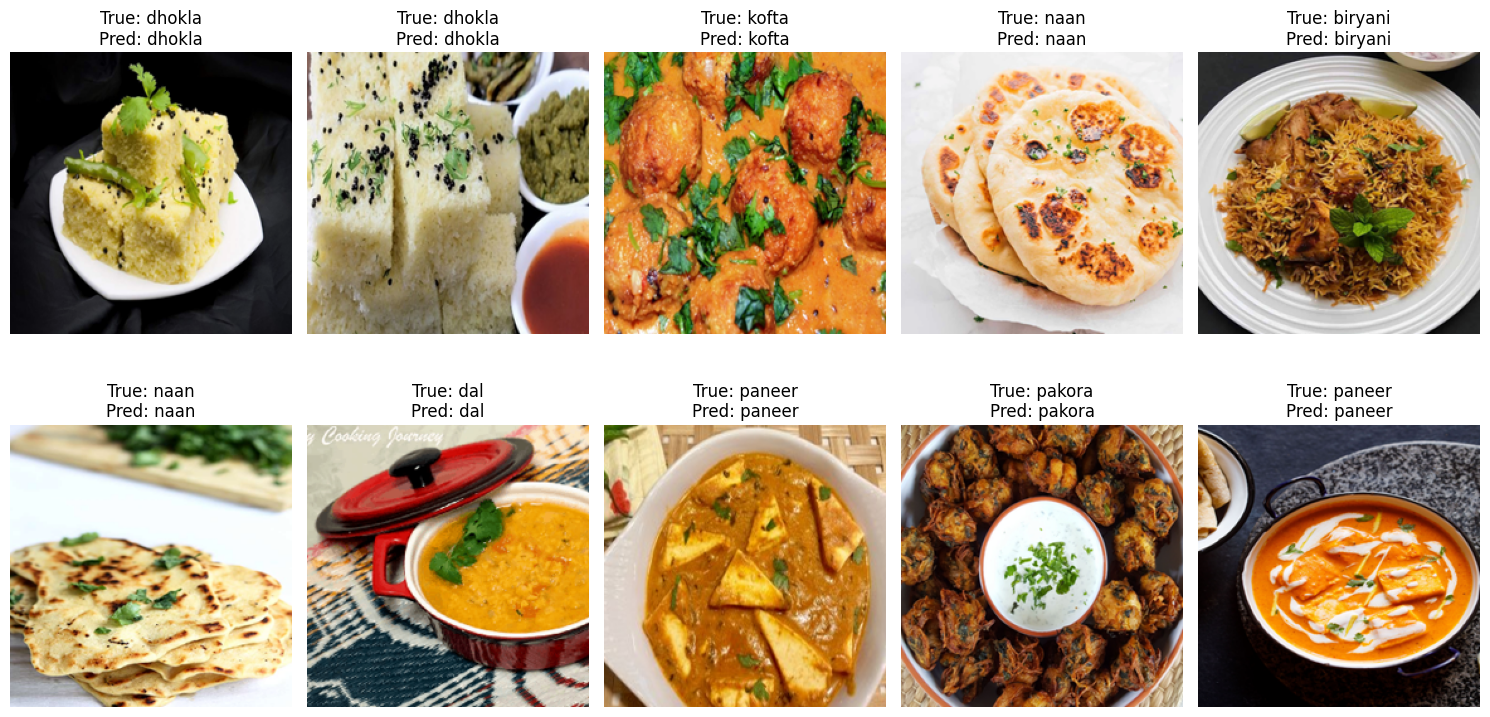

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8)) 
axes = axes.ravel() 

for i, idx in enumerate(random_indices):
    ax = axes[i]

    img_tensor = test_dataset[idx]['pixel_values']
    img_tensor = denormalize(img_tensor, mean, std)
    img_tensor = torch.clamp(img_tensor, 0, 1)
    img = img_tensor.permute(1, 2, 0).numpy() 
    img = (img * 255).astype(np.uint8)  
    ax.imshow(img)
    ax.axis('off')  
    
    true_label = y_true[idx]
    predicted_label = y_pred[idx]
    
    class_names = test_dataset.features['label'].names
    
    ax.set_title(f'True: {class_names[true_label]}\nPred: {class_names[predicted_label]}')

plt.tight_layout()
plt.show()